# Canada's Target Gap

Each party to the Paris Agreement creates a nationally determined contribution (NDC) or intended nationally determined contribution (INDC), these non-binding national plans highlight climate change mitigation, including climate-related targets for greenhouse gas emission reductions. Non-state actors on the other hand are not formally recognized in the Paris agreement's global stocktake. Eventhough some non-state actors have pledged targets and actions at these levels are important. However, some of these provincial targets have not been revised in some time. For instance, Alberta, which is repsonsible for the majority of Canada's emissions released their [Climate Change Strategy](https://open.alberta.ca/dataset/e86a9861-aa19-400e-bb7a-909ef8ccfe46/resource/ad5754f4-cc7f-40bf-a2ad-0775bd83ba7e/download/4063885-2008-albertas-2008-climate-change-strategy.pdf) in 2008. This plan called for 14% reduction below 2005 levels by 2050, with the majority of the reduction coming from carbon capture and storage (CCS).

This notebook uses nationally reported data from the UNFCCC and provincial data from ECCC, as well as pledged targets, to estimate whether the provincial pledges are adequate to achieve the national goal. We find that these pledges are not adequate to achieve Canada's NDC goal. Assuming the emissions from provinces without targets remain constant at pre-pandemic 2019 levels, Canada will be about 167 MtCO2e shy of their NDC goal. 

As outlined in the [AR6 summary for policymakers (SPM)](https://report.ipcc.ch/ar6syr/pdf/IPCC_AR6_SYR_SPM.pdf), feasible, effective, and low-cost options for mitigation and adaptation are already available. Large contributions to emissions reductions with costs less than USD 20 tCO2e come from solar and wind energy. Actions that support deep reductions in emissions should come before focusing on nascent carbon dioxide reduction (CDR) solutions (see [Ho, (2023)](https://www.nature.com/articles/d41586-023-00953-x))

In [1]:
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import openclimate as oc
import pandas as pd

In [2]:
def get_emissions(part, data_id=None):
    data_id = 'ECCC:GHG_inventory:2022-04-13' if data_id is None else data_id
    try:
        return client.emissions(actor_id=part, datasource_id=data_id)
    except: 
        return None

def get_target(part, year, data_id = None):
    data_id = 'C2ES:canadian_GHG_targets' if data_id is None else data_id
    try:
        part_targets = (
            client.targets(actor_id = part, ignore_warnings=True)
            .loc[lambda x: x['target_type'] == 'Absolute emission reduction', 
                 ['actor_id', 'baseline_year', 'target_year', 'target_value', 'target_unit', 'datasource_id']]
        ) 
        
        part_target = part_targets.loc[part_targets['datasource_id']== data_id]
        
        closest_target = part_targets['target_year'][part_targets['target_year'] >= 2030].min()
        cols_out = ['actor_id', 'baseline_year', 'target_year','target_value', 'target_unit']
        target = part_targets.loc[part_targets['target_year'] == closest_target, cols_out]
        return target
    except:
        return None
    
def least_squares_regression(x, y):
    # Calculate the slope and intercept using normal equations
    X = np.vstack([x, np.ones(len(x))]).T
    theta = np.linalg.inv(X.T @ X) @ X.T @ y
    slope, intercept = theta[0], theta[1]
    predict = lambda x: slope * x + intercept
    return {"slope": slope, "intercept": intercept, "equation": predict}


In [3]:
# Inititaliate OpenClimate
client = oc.Client()
client.jupyter

# Get country emissions and targets

In [4]:
iso2 = 'CA'
data_id = 'UNFCCC:GHG_ANNEX1:2019-11-08'

tonnes_to_megatonnes = 1 / 10**6

actor_parts = client.parts(actor_id = iso2, part_type = 'adm1')
df_nat = client.emissions(actor_id = iso2, datasource_id=data_id)

nat_targets = (
    client.targets(actor_id = iso2)
    .loc[lambda x: x['target_type'] == 'Absolute emission reduction', 
         ['actor_id', 'baseline_year', 'target_year', 'target_value', 'target_unit']]
) 

df_target = nat_targets.drop_duplicates().reset_index().iloc[-1]
baseline_year = int(df_target['baseline_year'])
baseline_emissions = float(df_nat.loc[df_nat['year'] == baseline_year, 'total_emissions']) * tonnes_to_megatonnes 
target_year = int(df_target['target_year'])
percent = int(df_target['target_value']) 
percent_decimal = percent / 100
emissions_cut = baseline_emissions * percent_decimal
target_emissions = baseline_emissions - emissions_cut

data = {
    'actor_id': iso2, 
    'baseline_year': baseline_year,
    'baseline_emissions': baseline_emissions,
    'target_year': target_year,
    'target_emissions':target_emissions, 
    'emissions_reduction': emissions_cut, 
    'target_percent': percent
}

national = pd.DataFrame(data, index=[0])

In [5]:
national

,actor_id,baseline_year,baseline_emissions,target_year,target_emissions,emissions_reduction,target_percent
0,CA,2005,741.182843,2030,407.650564,333.532279,45


# Get province emissions and targets

In [6]:
data_raw = []
data_scaled = []

tonnes_to_megatonnes = 1 / 10**6

for part in actor_parts['actor_id']:
    data_id = 'ECCC:GHG_inventory:2022-04-13'
    year = 2030
    df_part = get_emissions(part, data_id)
        
    try:
        df_target = get_target(part, year).drop_duplicates().reset_index().iloc[-1]
        baseline_year = int(df_target['baseline_year'])
        baseline_emissions = float(df_part.loc[df_part['year'] == baseline_year, 'total_emissions']) * tonnes_to_megatonnes
        target_year = int(df_target['target_year'])
        percent = int(df_target['target_value'])
        percent_decimal = percent / 100
        emissions_cut = baseline_emissions * percent_decimal
        n_years = target_year - baseline_year
        emissions_cut_per_year = emissions_cut / n_years                        
        target_emissions = baseline_emissions - emissions_cut
        
        data_raw.append(
            {
            'actor_id': part, 
            'baseline_year': baseline_year,
            'baseline_emissions': baseline_emissions,
            'target_year': target_year, 
            'target_emissions':target_emissions, 
            'emissions_reduction': emissions_cut,
            'avg_reduction_per_year': emissions_cut_per_year,
            'percent': percent
            }
        )
        
        if target_year>year:
            x = [baseline_year, target_year]
            y = [baseline_emissions, target_emissions]
            lsr_dict = least_squares_regression(x, y)
            lsr = lsr_dict['equation']
            target_year = year
            target_emissions = lsr(target_year)
            emissions_cut = baseline_emissions * percent_decimal
            emissions_cut_per_year = emissions_cut / (target_year - baseline_year)
            
        data_scaled.append(
            {
            'actor_id': part, 
            'baseline_year': baseline_year,
            'baseline_emissions': baseline_emissions,
            'normalized_target_year': target_year, 
            'target_emissions':target_emissions, 
            'emissions_reduction': emissions_cut,
            'avg_reduction_per_year': emissions_cut_per_year,
            'percent_reduction': percent
            }
        )
            
    except:
        continue

df_part_targets = pd.DataFrame(data_raw)
df_part_targets_scaled = pd.DataFrame(data_scaled)

Each province has targets with different baseline years, percent reduction, and target years

In [7]:
df_part_targets

,actor_id,baseline_year,baseline_emissions,target_year,target_emissions,emissions_reduction,avg_reduction_per_year,percent
0,CA-AB,2005,237.093201,2050,203.900153,33.193048,0.737623,14
1,CA-BC,2007,62.658881,2030,37.595329,25.063552,1.089720,40
2,CA-MB,2005,20.530551,2030,13.755469,6.775082,0.271003,33
3,CA-NB,2005,19.781112,2030,10.681800,9.099312,0.363972,46
4,CA-NL,2001,9.899129,2050,2.474782,7.424347,0.151517,75
5,CA-NS,2005,22.963779,2030,10.792976,12.170803,0.486832,53
6,CA-NT,2005,1.725190,2030,0.862595,0.862595,0.034504,50
7,CA-ON,2005,204.370140,2030,143.059098,61.311042,2.452442,30
8,CA-PE,2005,1.899135,2030,1.329395,0.569740,0.022790,30
9,CA-QC,1990,84.508702,2030,53.240482,31.268220,0.781705,37


In order to accurately compare the effectiveness of these targets to achieving the national goal, we scale all the pledges to 2030 (the target year at the national level) assuming linear rate of reduction

In [8]:
df_part_targets_scaled

,actor_id,baseline_year,baseline_emissions,normalized_target_year,target_emissions,emissions_reduction,avg_reduction_per_year,percent_reduction
0,CA-AB,2005,237.093201,2030,218.652619,33.193048,1.327722,14
1,CA-BC,2007,62.658881,2030,37.595329,25.063552,1.089720,40
2,CA-MB,2005,20.530551,2030,13.755469,6.775082,0.271003,33
3,CA-NB,2005,19.781112,2030,10.681800,9.099312,0.363972,46
4,CA-NL,2001,9.899129,2030,5.505128,7.424347,0.256012,75
5,CA-NS,2005,22.963779,2030,10.792976,12.170803,0.486832,53
6,CA-NT,2005,1.725190,2030,0.862595,0.862595,0.034504,50
7,CA-ON,2005,204.370140,2030,143.059098,61.311042,2.452442,30
8,CA-PE,2005,1.899135,2030,1.329395,0.569740,0.022790,30
9,CA-QC,1990,84.508702,2030,53.240482,31.268220,0.781705,37


# Calculate target gap
If the provinces are on track to meeting Canada's NDC goal, then the sum of each provincial emissions in the target yeat ($E_{prov}$) will equal the national emissions in the target yeat ($E_{nat}$). However, if the provincial emissions are either not enough or overshoot the national goal, there will be an emissions gap ($E_{gap}$), if this gap is positive then the provincial is not enough to meet the goal and if the gap is negative, the provinces have overachieved the goal.

$E_{nat} + E_{gap}= \sum_{prov=1}^N E_{prov}$

In this section of the notebook, we will calculate this gap as follows:

$E_{gap} = \big(\sum_{prov=1}^N E_{prov}\big) - E_{nat}$

This only takes into account provinces with with targets. Two provinces, Saskatchewan and Nunavut, do not have targets. In this case, we will assume their emissions remain at pre-pandemic 2019 levels, as we are unsure as to their future emissions trajectory. The revised gap that takes into account emissions from Saskatchewan ($E_{2019,SK}$) and Nunavut ($E_{2019,NU}$):

$E_{gap} = \big(\sum_{prov=1}^N E_{prov}\big) + E_{2019,SK} + E_{2019,NU} - E_{nat}$

In [9]:
sum_subat_target = df_part_targets_scaled['target_emissions'].sum() 
national_target = float(national['target_emissions'].values) 

gap = sum_subat_target - national_target

print(f'''
If each province meets their goal (ignoring emissiong from Saskatchewan and Nunavut), 
there will still be an {round(gap)} MtCO2e gap in the target. 
''')


If each province meets their goal (ignoring emissiong from Saskatchewan and Nunavut), 
there will still be an 88 MtCO2e gap in the target. 



In [10]:
missing_actors = list(set(actor_parts['actor_id']) - set(df_part_targets['actor_id']))
data_id = 'ECCC:GHG_inventory:2022-04-13'
df_missing = get_emissions(missing_actors, data_id)
df_missing = df_missing.assign(total_emissions = df_missing['total_emissions'] / 10**6)
missing_emissions = df_missing.loc[(df_missing['actor_id'].isin(missing_actors)) & (df_missing['year'] == 2019), 'total_emissions'].sum()
gap_revised = (sum_subat_target + missing_emissions) - national_target

print(f'''
If we assume Saskatchewan and Nunavut emissions remain constant at pre-pandemic levels,
then the emissions gap increases to {round(gap_revised)} MtCO2e. 
''')


If we assume Saskatchewan and Nunavut emissions remain constant at pre-pandemic levels,
then the emissions gap increases to 167 MtCO2e. 



In [11]:
print(f'''
This emissions gap is similar to the reductions from all the pledges {round(df_part_targets_scaled['emissions_reduction'].sum())} MtCO2e.
Meaning provincial commitments need to roughly double to meet the national goal.
''')


This emissions gap is similar to the reductions from all the pledges 188 MtCO2e.
Meaning provincial commitments need to roughly double to meet the national goal.



# Create figure

In [12]:
df_tmp = (
    df_missing
    .loc[(df_missing['actor_id'].isin(missing_actors)) & (df_missing['year'] == 2019), ['actor_id','total_emissions']]
    .rename(columns={'total_emissions':'target_emissions'})
)

df_fin = pd.concat([df_part_targets_scaled[['actor_id', 'target_emissions']], df_tmp]).reset_index(drop=True)
df_fin = df_fin.sort_values(by='target_emissions', ascending=False)
df_fin['cumulative'] = df_fin['target_emissions'].cumsum()

Text(0, 0.5, 'Emissions (MTCO$_2$-eq)')

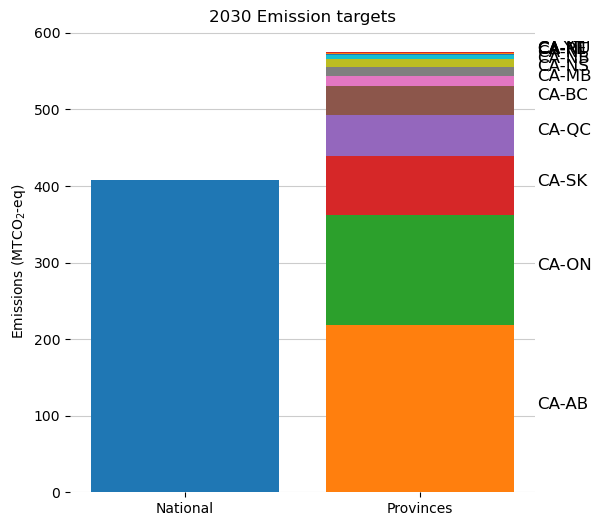

In [13]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.bar(0, national['target_emissions'], bottom=0, label='CA')

previous = 0
for iterator, row in df_fin.iterrows():
    emissions = row['target_emissions']
    cumulative = row['cumulative']
    actor_id = row['actor_id']
    ax.bar(1, emissions, bottom=previous, label=actor_id)
    previous = cumulative
    ax.text(1.5, previous - (emissions/2),
          actor_id,
          fontsize=12,
          color='k')

# Turn off the display of all ticks.
ax.tick_params(which='both',     # Options for both major and minor ticks
               top='off',        # turn off top ticks
               left='off',       # turn off left ticks
               right='off',      # turn off right ticks
               bottom='off')     # turn off bottom ticks

# Remove x tick marks
plt.setp(ax.get_xticklabels(), rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# grid and tick marks
ax.set_yticks(np.arange(0, 700, 100))
ax.grid(axis='y',
        which='major',
        color=[0.8, 0.8, 0.8], linestyle='-')

ax.set_axisbelow(True)
ax.set_xticks([0, 1])
ax.set_xticklabels(['National', 'Provinces'])
ax.set_title("2030 Emission targets")
ax.set_ylabel("Emissions (MTCO$_2$-eq)")